# Harebnb - Commercial Client Performance Report

The Product Development Team at Harebnb have engaged me to query their platform database and build a reusable monthly performance report for their most important commercial clients. 

There are some key fields from various tables within the Harebnb database that are required to be extracted and transformed prior to loading them into the client dashboard.  

Based on the requirements for the MVP as described by the team, the below columns will be necessary for our backend report data:

- Date, Month, Year
- Location Name
- Location Owner
- Impressions
- Clicks
- New Bookings
- Total Revenue

Let's take a quick look at the Harebnb platform database to understand how the various tables relate and store data. 

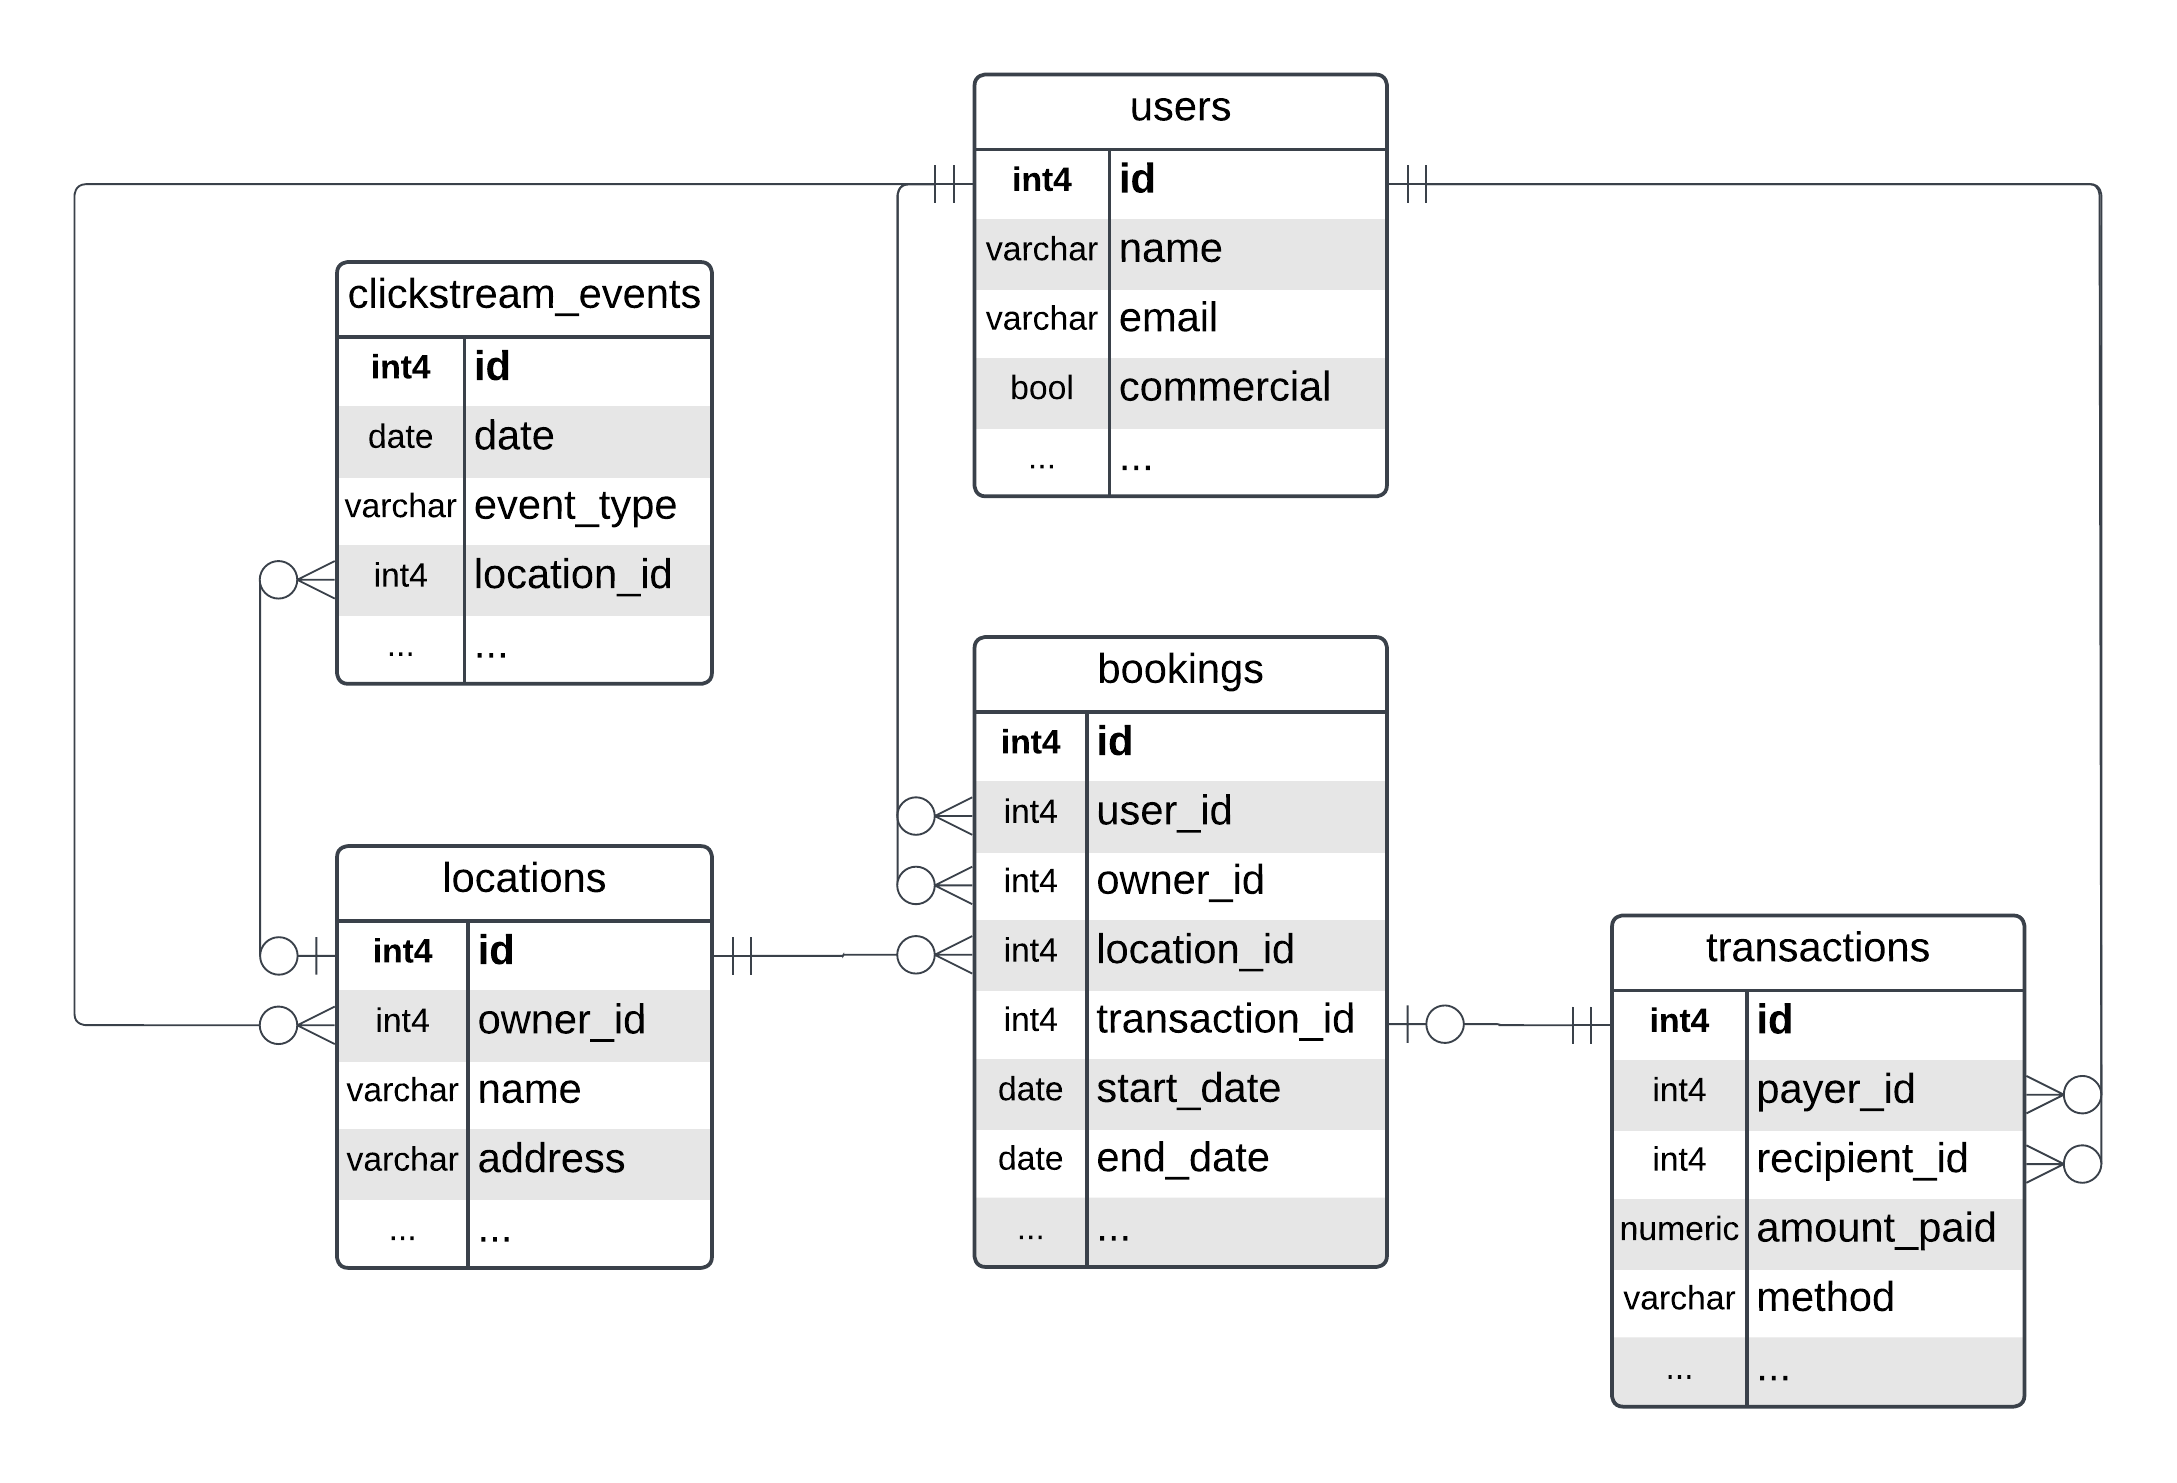

We can now extract and transform our data from an informed position. Let's get started. 

<br>

In [ ]:
/*Define Start and End of Query Daterange in CTE*/
WITH report_range AS (
    SELECT 
    CAST ('2024-01-01' AS date) "start",
    CAST ('2024-12-31' AS date) "end"
),

event_ledger AS (
    /*Fetch all listing impressions and clicks from clickstream_events table.*/
	SELECT
    clickstream_events.date,
	clickstream_events.event_type,
    0 AS total_revenue,
	CONCAT(owner.name, ' - ', location.name) AS location,
    owner.name AS owner
	
	FROM harebnb_clickstream_events AS "clickstream_events"
	LEFT JOIN harebnb_locations AS "location" ON (location.id = clickstream_events.location_id)
    LEFT JOIN harebnb_users AS "owner" ON (owner.id = location.owner_id)

	WHERE clickstream_events.event_type IN ('impression','click') AND owner.commercial IS TRUE

	UNION

	/*Fetch all new bookings and revenue from bookings and transactions table.*/
	SELECT
    booking.start_date AS date,
	'new booking' AS event_type,
    transaction.amount_paid AS total_revenue,
	CONCAT(owner.name, ' - ', location.name) AS location,
    owner.name AS owner
	
	FROM harebnb_bookings AS "booking"
	LEFT JOIN harebnb_locations AS "location" ON (location.id = booking.location_id)
    LEFT JOIN harebnb_users AS "owner" ON (owner.id = location.owner_id)
    LEFT JOIN harebnb_transactions AS "transaction" ON (transaction.id = booking.transaction_id)

	WHERE booking.cancelled IS FALSE AND owner.commercial IS TRUE
)
    
/*Aggregate numeric fields from event ledger and group records by date and location*/
SELECT 
event_ledger.event_date,
event_ledger.location,
event_ledger.owner,
SUM(CASE WHEN event_ledger.event_type LIKE 'impression' THEN 1 ELSE 0 END) AS impressions,
SUM(CASE WHEN event_ledger.event_type LIKE 'click' THEN 1 ELSE 0 END) AS clicks,
SUM(CASE WHEN event_ledger.event_type LIKE 'new booking' THEN 1 ELSE 0 END) AS new_bookings,
SUM(event_ledger.total_revenue) AS total_revenue 


FROM report_range, event_ledger

WHERE event_ledger.event_date >= report_range.start AND event_ledger.event_date <= report_range.end

GROUP BY event_ledger.event_date, event_ledger.location
ORDER BY event_ledger.event_date, "total_revenue" DESC

<br>

| `event_date` | `location` | `owner` |	`impressions` | `clicks` | `new_bookings` | `total_revenue` |
|--------------|------------|---------|---------------|----------|----------------|-----------------|
| 01/01/2024 | Pet Hotel - Brisbane CBD | Pet Hotel | 106 | 48 | 5 | 2150 |
| 01/01/2024 | Feline Fine - North Sydney | Feline Fine | 167 | 75 | 8 | 750 |
| 01/01/2024 | Pet Hotel - Sydney CBD | Pet Hotel | 141 | 63 | 6 | 750 |
| 01/01/2024 | Pet Hotel - Melbourne CBD | Pet Hotel | 165 | 74 | 7 | 600 |
| 01/01/2024 | Trot Here - Perth Stables | Trot Here | 120 | 54 | 5 | 330 |
| 02/01/2024 | Pet Hotel - Brisbane CBD | Pet Hotel | 179 | 81 | 8 | 1550 |
| 02/01/2024 | Pet Hotel - Melbourne CBD | Pet Hotel | 130 | 59 | 6 | 692 |
| ... | ... | ... | ... | ... | ... | ... | ... |
+1778 records

<br>

The transformed data is looking clean and useful. Furthermore, some quick exploration in excel has revealed that there are no null fields and no duplicate groupings of date, location and owner. 

We should move on to loading the data and designing our [dashboard interface](https://lookerstudio.google.com/reporting/f619017b-c8f9-495f-be02-daf9a914ff64/page/p_wmplyauqmd).